# Skill 6: Eyes and Ears. Adding Multi-modality

In this notebook, we’ll explore how to expand our bot's capabilities beyond text. Up to this point, we've built agents that can interact with APIs, databases, search engines, and structured files like CSVs. Now, it's time to give our system **eyes and ears** – enabling it to interact with the world through **audio and visual data**.

We’ll introduce **multimodal capabilities** that will allow our bot to process and generate audio and image-based content using cutting-edge tools:

- **OpenAI Whisper** for **Speech-to-Text** transcription 
- **OpenAI TTS** for lifelike text-to-speech synthesis 
- **Azure Speech SDK** for **Text-to-Speech (TTS)** and **Speech-to-Text (STT)**    
- **Vision models** for interpreting images and extracting text via OCR  

### What You’ll Learn in This Notebook:
1. How to enable your bot to **interpret and extract information from images**.  
2. How to **convert speech into text** (STT) and **generate speech from text** (TTS).  

By the end of this notebook, you'll have all the tools to create a bot that can **see, hear, and speak**, opening the door for richer and more interactive user experiences. 

Let’s get started! 🚀


## Setup and Environment

In [1]:
import os
import requests
from IPython.display import Audio, Image, Markdown
from PIL import Image as PILImage
from io import BytesIO

import re

from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage

# If you want environment variables loaded, do it here:
from dotenv import load_dotenv
load_dotenv("credentials.env")

# Import our consolidated helper module
import common.audio_utils  as audio_utils 

def printmd(string):
    # Remove ```markdown and ``` from the text
    clean_content = re.sub(r'^```markdown\n', '', string)
    clean_content = re.sub(r'^```\n', '', clean_content)
    clean_content = re.sub(r'\n```$', '', clean_content)

    # Escape dollar signs to prevent LaTeX rendering
    clean_content = clean_content.replace('$', r'\$')
    display(Markdown(clean_content))


Declare the Azure OpenAI model:

In [2]:
COMPLETION_TOKENS = 2000

llm = AzureChatOpenAI(deployment_name=os.environ["GPT4oMINI_DEPLOYMENT_NAME"], 
                      temperature=0, max_tokens=COMPLETION_TOKENS, 
                      streaming=True)                            


## Vision

The GPT-4o model supports multimodal inputs, allowing it to process both text and images. Let’s test its ability to analyze and extract content from different types of images.

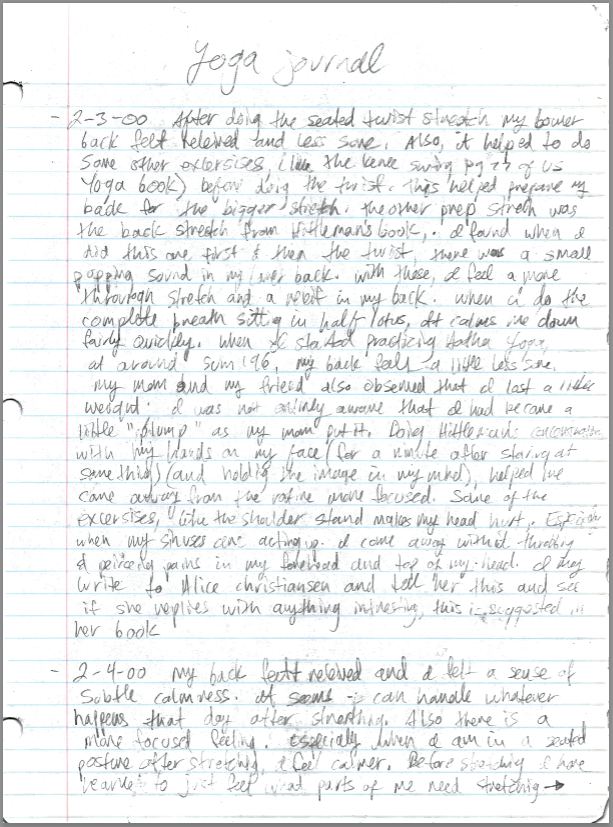

In [3]:
# Invoice image
# image_url = "https://docs.swissuplabs.com/images/m2/pdf-invoices/frontend/invoice-stripes.png"
# Scanned book page
# image_url = "https://www.digitalhumanities.org/dhq/vol/7/1/000150/resources/images/image12.png"
# Handwriten text
image_url = "https://community.adobe.com/legacyfs/online/1284499_pastedImage_10.png"
# Image with tilted  text 
# image_url = "https://www.panosfx.com/templates/yootheme/cache/d0/Single-billboard-photoshop-template-800px-d05f9c14.jpeg"

# Fetch and display the image
response = requests.get(image_url)
img = PILImage.open(BytesIO(response.content))
display(img)


In LangChain, we can enable multimodal capabilities by specifying the input type in the HumanMessage.

In [4]:
%%time

message = HumanMessage(
    content=[
        {"type": "text", 
            "text": "Perform OCR: answer with the markdown of the text content of the image. Visually appealing markdown, Nothing else."},
        {"type": "image_url", 
            "image_url": {"url": image_url}
        },
    ],
)
response = llm.invoke([message])

CPU times: total: 203 ms
Wall time: 5.08 s


In [5]:
response.content

'```markdown\n# Yoga Journal\n\n**2-3-00**  \nAfter doing the seated twist stretch, my lower back felt relieved and less sore. Also, it helped to do some other exercises, like the knee swing. I got a yoga book before doing this that helped provide my back for the bigger stretch. The other prep stretch was the back stretch from the human\'s body, I found when I did this one that there was a small popping sound in my lower back. With these, I feel a more thorough stretch and a relief in my back. When I do the compound breath still in half poses, it calms me down fairly quickly. When I started practicing today at around 5:00 PM, my back felt a little less sore. My mom and my friend also observed that I had a little more "puff" as my mom put it. I felt little twinges with my hands on my face (for a while after staring at something) and noticed more focused. Some of the exercises, like the shoulder stand, made my head hurt. Especially when my shoes came off. I could come up with a better pi

In [6]:
printmd(response.content)

# Yoga Journal

**2-3-00**  
After doing the seated twist stretch, my lower back felt relieved and less sore. Also, it helped to do some other exercises, like the knee swing. I got a yoga book before doing this that helped provide my back for the bigger stretch. The other prep stretch was the back stretch from the human's body, I found when I did this one that there was a small popping sound in my lower back. With these, I feel a more thorough stretch and a relief in my back. When I do the compound breath still in half poses, it calms me down fairly quickly. When I started practicing today at around 5:00 PM, my back felt a little less sore. My mom and my friend also observed that I had a little more "puff" as my mom put it. I felt little twinges with my hands on my face (for a while after staring at something) and noticed more focused. Some of the exercises, like the shoulder stand, made my head hurt. Especially when my shoes came off. I could come up with a better piece of paper in my hand and get it typed. I may write to Alice Christiansen and tell her this and see if she replies with anything interesting. This is suggested in her book.

**2-4-00**  
My back felt renewed and I felt a sense of subtle calmness. It seemed I could handle whatever happens that day after stretching. Also, there is a more focused feeling, especially when I am in a seated posture after stretching. I feel calmer, but I do leave to just keep in mind parts of me need stretching. ➔

**Key Observations**:

- The response displays the extracted text in a clean and formatted way.
- Vision tasks, including OCR and image analysis, are seamlessly handled by GPT-4o.
- Changing the prompt to "Describe this image" will switch the task from OCR to general image analysis.

## Audio (not-realtime)
There are two primary modes for audio integration:

1. Non-Realtime Audio Processing: Using OpenAI's Whisper and TTS models.
2. You also have the option to use the Azure Speech Service, which you can set on the `credentials.env` file.
3. Realtime Audio Processing: Using models like gpt-4o-realtime-preview (out of scope for this notebook).

In [7]:
# Confirm which engine is in use:
print(f"Using speech engine: {audio_utils.SPEECH_ENGINE}")

Using speech engine: openai


In the folder `/common/` you will find a file called `audio_utils.py`. 
This file contains all the functions that we will use going forward and on the apps in order to integrate audio.

#### 1. TEXT-TO-SPEECH

We’ll use the text response from the Vision section to generate audio.

In [8]:
%%time

sample_text = response.content

print("[INFO] Generating TTS from sample text...")

output_wav = audio_utils.text_to_speech(sample_text)

if output_wav and os.path.exists(output_wav):
    print(f"[SUCCESS] TTS wav saved to: {output_wav}")
    display(Audio(output_wav, autoplay=True))
else:
    print("TTS did not produce an output file.")

[INFO] Generating TTS from sample text...
[SUCCESS] TTS wav saved to: temp_audio_play.wav


CPU times: total: 969 ms
Wall time: 8.06 s


**Note**: For long text (over 50 words), the TTS function will summarize the content to keep audio duration under 20 seconds. You can adjust this behavior in `audio_utils.py`

#### 2. SPEECH-TO-TEXT

Convert the generated speech back into text using Whisper.

In [9]:
%%time

audio_file_path = output_wav 
print("[INFO] Transcribing audio from file...")

transcript = audio_utils.speech_to_text_from_file(audio_file_path)
print(f"Transcript:\n{transcript}")

[INFO] Transcribing audio from file...
Transcript:
Yoga journal entries describe relief and calmness from stretches like the seated twist and knee swing, along with improved focus. Some poses cause discomfort, but overall, stretching renewed energy and reduced soreness. The writer plans to share their experience with Alice Christensen. Refer to the full text answer for more details.

CPU times: total: 0 ns
Wall time: 1.92 s


# Summary

In this notebook, we added multimodal capabilities to our bot, enabling it to process both images and audio.

Key Takeaways:
- GPT-4o excels at image interpretation and OCR tasks.
- Adding image inputs is as simple as specifying the type in the HumanMessage.
- Text-to-Speech (TTS) and Speech-to-Text (STT) enable seamless audio capabilities.
- For long text, TTS audio outputs are summarized for clarity and efficiency.



# NEXT

The Next Notebook will guide you on how we stick everything together. How do we use the features of all notebooks and create a brain/supervisor agent that can respond to any request accordingly.